# =============================================================================
# CELL 1: Install and Import Required Libraries
# =============================================================================

In [26]:
# Cell 1: Install and Import Libraries
!pip install opencv-python-headless scikit-image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Traditional ML and Computer Vision
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
import pickle

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.18.0


# =============================================================================
# CELL 2: GPU Configuration and Dataset Loading
# =============================================================================

Found 4298 images from 128 persons


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Dataset loaded successfully!
Total images: 4298
Image shape: (128, 128)
Number of classes: 128


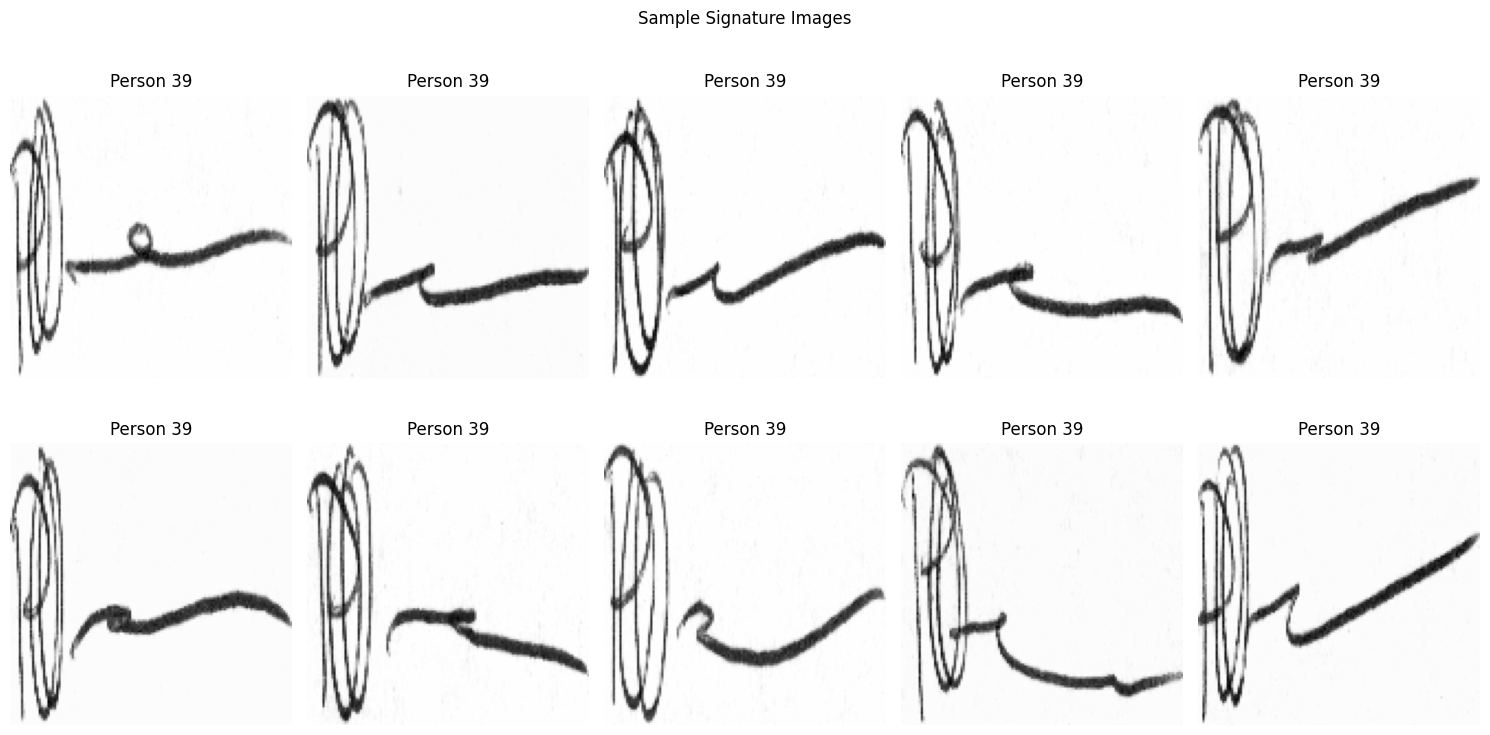

In [27]:
# Cell 2: Load and Preprocess Dataset
def load_signature_dataset():
    """
    Load the signature verification dataset from Kaggle
    Expected structure: /kaggle/input/signature-verification-dataset/
    """
    
    # Check if running on Kaggle
    if os.path.exists('/kaggle/input/signature-verification-dataset'):
        base_path = '/kaggle/input/signature-verification-dataset'
    else:
        # For Colab, you need to upload the dataset manually
        print("Please upload the dataset to Colab or use Kaggle environment")
        return None, None, None
    
    # Find all image files
    image_paths = []
    labels = []
    person_names = []
    
    # Walk through the directory structure
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                image_paths.append(file_path)
                
                # Extract person name from path
                # Assuming structure: .../person_name/signature_file.jpg
                person_folder = os.path.basename(os.path.dirname(file_path))
                person_names.append(person_folder)
    
    # Create unique labels
    unique_persons = list(set(person_names))
    person_to_label = {person: idx for idx, person in enumerate(unique_persons)}
    labels = [person_to_label[person] for person in person_names]
    
    print(f"Found {len(image_paths)} images from {len(unique_persons)} persons")
    
    return image_paths, labels, unique_persons

def preprocess_images(image_paths, target_size=(128, 128)):
    """
    Load and preprocess images
    """
    images = []
    valid_indices = []
    
    for i, path in enumerate(image_paths):
        try:
            # Load image
            img = cv2.imread(path)
            if img is None:
                continue
                
            # Convert to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Resize
            img = cv2.resize(img, target_size)
            
            # Normalize
            img = img.astype('float32') / 255.0
            
            images.append(img)
            valid_indices.append(i)
            
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            continue
    
    return np.array(images), valid_indices

# Load dataset
image_paths, labels, person_names = load_signature_dataset()

if image_paths is not None:
    # Preprocess images
    X, valid_indices = preprocess_images(image_paths)
    y = np.array([labels[i] for i in valid_indices])
    
    print(f"Dataset loaded successfully!")
    print(f"Total images: {len(X)}")
    print(f"Image shape: {X[0].shape if len(X) > 0 else 'No images'}")
    print(f"Number of classes: {len(np.unique(y)) if len(y) > 0 else 0}")
    
    # Visualize some samples
    if len(X) > 0:
        plt.figure(figsize=(15, 8))
        for i in range(min(10, len(X))):
            plt.subplot(2, 5, i+1)
            plt.imshow(X[i], cmap='gray')
            plt.title(f'Person {y[i]}')
            plt.axis('off')
        plt.suptitle('Sample Signature Images')
        plt.tight_layout()
        plt.show()
else:
    print("Dataset not found. Please ensure you're running on Kaggle or upload the dataset manually.")

# =============================================================================
# Cell 3: Train-Test Split and CNN Implementation
# =============================================================================

In [28]:
# Cell 3: Train-Test Split and CNN Implementation
# Ensure we have data
if len(X) == 0:
    print("No data available. Please check dataset loading.")
else:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # Prepare data for CNN
    X_train_cnn = X_train.reshape(-1, 128, 128, 1)
    X_val_cnn = X_val.reshape(-1, 128, 128, 1)
    X_test_cnn = X_test.reshape(-1, 128, 128, 1)
    
    # Convert labels to categorical
    num_classes = len(np.unique(y))
    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

def create_cnn_model(input_shape, num_classes):
    """
    Create CNN model for signature classification
    """
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile CNN model
if len(X) > 0:
    cnn_model = create_cnn_model((128, 128, 1), num_classes)
    cnn_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("CNN Model Architecture:")
    cnn_model.summary()

Training set: 2750 samples
Validation set: 688 samples
Test set: 860 samples
CNN Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,275,136 (20.12 MB)

 Trainable params: 5,273,152 (20.12 MB)

 Non-trainable params: 1,984 (7.75 KB)

# Cell 4: Train CNN Model

Training CNN model...
Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.0365 - loss: 5.3951 - val_accuracy: 0.0116 - val_loss: 16.2992 - learning_rate: 0.0010
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.1250 - loss: 3.7802 - val_accuracy: 0.0116 - val_loss: 16.3644 - learning_rate: 0.0010
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.1543 - loss: 3.9835 - val_accuracy: 0.0116 - val_loss: 24.5072 - learning_rate: 0.0010
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.1250 - loss: 4.3184 - val_accuracy: 0.0116 - val_loss: 23.8958 - learning_rate: 0.0010
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2456 - loss: 3.2049 - val_accuracy: 0.0334 - val_loss: 10.7491 - learning_rate: 0.0010
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3125 - loss: 3.2413 - val_accuracy: 0.0334 - val_loss: 10.6717 - learning_rate: 0.0010
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step

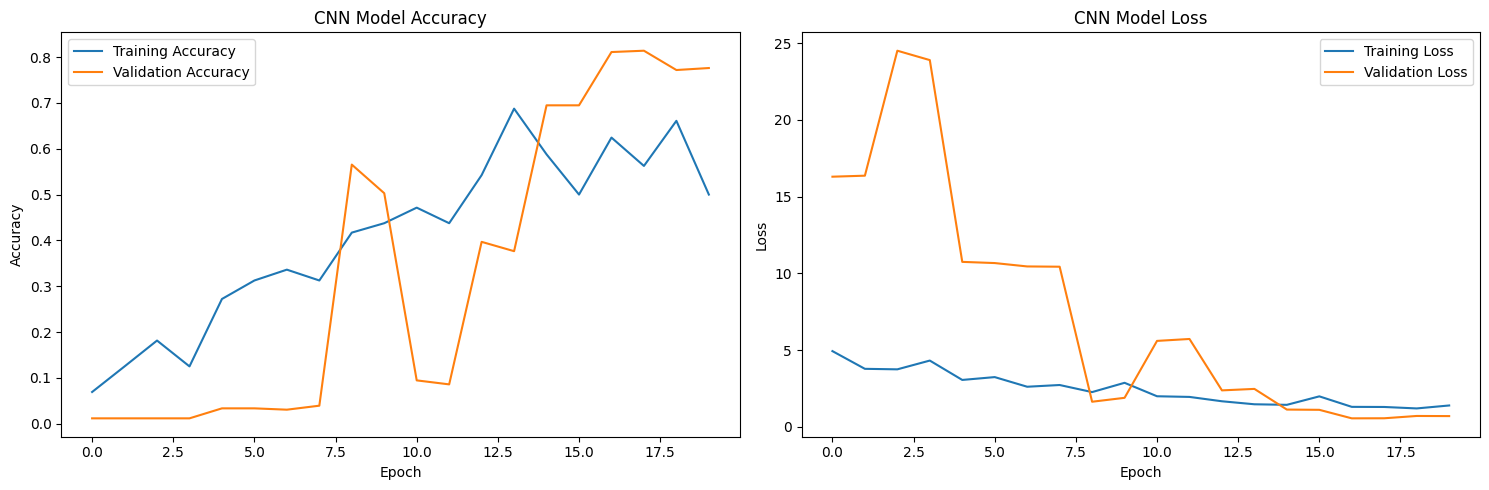

CNN Test Accuracy: 0.8477
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       1.00      0.60      0.75         5
           2       0.42      0.89      0.57         9
           3       1.00      1.00      1.00        10
           4       0.76      1.00      0.87        13
           5       0.80      0.80      0.80         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         6
           9       1.00      0.80      0.89         5
          10       0.80      0.80      0.80         5
          11       1.00      1.00      1.00         5
          12       0.69      1.00      0.82         9
          13       1.00      1.00      1.00         6
          14       1.00      0.60      0.75         5
          15       1.00      1.00      1.

In [29]:
# Cell 4: Train CNN Model
if len(X) > 0:
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False,  # Don't flip signatures
        fill_mode='nearest'
    )
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
    
    # Train the model with reduced epochs for faster execution
    print("Training CNN model...")
    history = cnn_model.fit(
        datagen.flow(X_train_cnn, y_train_cat, batch_size=16),  # Reduced batch size
        steps_per_epoch=len(X_train_cnn) // 16,
        epochs=20,  # Reduced epochs
        validation_data=(X_val_cnn, y_val_cat),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    print("CNN training completed!")
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate CNN on test set
    cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_cnn, y_test_cat, verbose=0)
    print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")
    
    # CNN Predictions
    cnn_predictions = cnn_model.predict(X_test_cnn)
    cnn_pred_classes = np.argmax(cnn_predictions, axis=1)
    
    # CNN Classification Report
    print("\nCNN Classification Report:")
    print(classification_report(y_test, cnn_pred_classes))

# =============================================================================
# Cell 5: Traditional Feature Extraction (HOG, LBP, and Statistical Features)
# =============================================================================

In [30]:
# Cell 5: Traditional Feature Extraction (HOG, LBP, and Statistical Features)
def extract_hog_features(images):
    """Extract HOG features from images"""
    hog_features = []
    
    for img in images:
        # Convert to uint8 if needed
        if img.dtype == np.float32 or img.dtype == np.float64:
            img_uint8 = (img * 255).astype(np.uint8)
        else:
            img_uint8 = img
            
        # Extract HOG features
        features = hog(
            img_uint8,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False,
            transform_sqrt=True
        )
        hog_features.append(features)
    
    return np.array(hog_features)

def extract_lbp_features(images):
    """Extract Local Binary Pattern features"""
    lbp_features = []
    
    for img in images:
        # Convert to uint8 if needed
        if img.dtype == np.float32 or img.dtype == np.float64:
            img_uint8 = (img * 255).astype(np.uint8)
        else:
            img_uint8 = img
            
        # Calculate LBP
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img_uint8, n_points, radius, method='uniform')
        
        # Calculate histogram
        hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2))
        hist = hist.astype(float)
        hist /= (hist.sum() + 1e-7)  # Normalize
        
        lbp_features.append(hist)
    
    return np.array(lbp_features)

def extract_statistical_features(images):
    """Extract basic statistical features"""
    statistical_features = []
    
    for img in images:
        features = []
        
        # Basic statistics
        features.extend([
            np.mean(img),
            np.std(img),
            np.var(img),
            np.min(img),
            np.max(img),
            np.median(img)
        ])
        
        # Moments
        features.extend([
            np.mean((img - np.mean(img))**3),  # Skewness
            np.mean((img - np.mean(img))**4)   # Kurtosis
        ])
        
        statistical_features.append(features)
    
    return np.array(statistical_features)

if len(X) > 0:
    print("Extracting traditional features...")
    
    # Extract features
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)
    
    # HOG Features
    print("Extracting HOG features...")
    hog_train = extract_hog_features(X_train)
    hog_test = extract_hog_features(X_test)
    
    # LBP Features
    print("Extracting LBP features...")
    lbp_train = extract_lbp_features(X_train)
    lbp_test = extract_lbp_features(X_test)
    
    # Statistical Features
    print("Extracting statistical features...")
    stat_train = extract_statistical_features(X_train)
    stat_test = extract_statistical_features(X_test)
    
    # Combine all traditional features
    traditional_train = np.hstack([hog_train, lbp_train, stat_train])
    traditional_test = np.hstack([hog_test, lbp_test, stat_test])
    
    print(f"HOG features shape: {hog_train.shape}")
    print(f"LBP features shape: {lbp_train.shape}")
    print(f"Statistical features shape: {stat_train.shape}")
    print(f"Combined traditional features shape: {traditional_train.shape}")
    
    # Standardize features
    scaler = StandardScaler()
    traditional_train_scaled = scaler.fit_transform(traditional_train)
    traditional_test_scaled = scaler.transform(traditional_test)
    
    print("Traditional feature extraction completed!")

Extracting traditional features...
Extracting HOG features...
Extracting LBP features...
Extracting statistical features...
HOG features shape: (2750, 8100)
LBP features shape: (2750, 26)
Statistical features shape: (2750, 8)
Combined traditional features shape: (2750, 8134)
Traditional feature extraction completed!


# * =============================================================================
# Cell 6: Train Traditional ML Models
# =============================================================================

In [31]:
# Cell 6: Train Traditional ML Models
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model, model_name):
    """Train and evaluate a traditional ML model"""
    
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    print(f"{model_name} - Train Accuracy: {train_acc:.4f}")
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")
    
    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, test_pred))
    
    return {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'predictions': test_pred
    }

if len(X) > 0:
    # Traditional ML Models
    models = {
        'SVM_HOG': SVC(kernel='rbf', random_state=42),
        'RandomForest_HOG': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM_Combined': SVC(kernel='rbf', random_state=42),
        'RandomForest_Combined': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    # Train models with HOG features only
    print("="*50)
    print("TRAINING MODELS WITH HOG FEATURES ONLY")
    print("="*50)
    
    results['SVM_HOG'] = train_and_evaluate_model(
        hog_train, hog_test, y_train, y_test,
        models['SVM_HOG'], 'SVM with HOG Features'
    )
    
    results['RandomForest_HOG'] = train_and_evaluate_model(
        hog_train, hog_test, y_train, y_test,
        models['RandomForest_HOG'], 'Random Forest with HOG Features'
    )
    
    # Train models with combined traditional features
    print("\n" + "="*50)
    print("TRAINING MODELS WITH COMBINED TRADITIONAL FEATURES")
    print("="*50)
    
    results['SVM_Combined'] = train_and_evaluate_model(
        traditional_train_scaled, traditional_test_scaled, y_train, y_test,
        models['SVM_Combined'], 'SVM with Combined Features'
    )
    
    results['RandomForest_Combined'] = train_and_evaluate_model(
        traditional_train_scaled, traditional_test_scaled, y_train, y_test,
        models['RandomForest_Combined'], 'Random Forest with Combined Features'
    )

TRAINING MODELS WITH HOG FEATURES ONLY

Training SVM with HOG Features...
SVM with HOG Features - Train Accuracy: 0.9996
SVM with HOG Features - Test Accuracy: 0.9453

SVM with HOG Features Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       1.00      1.00      1.00         5
           2       0.82      1.00      0.90         9
           3       1.00      1.00      1.00        10
           4       0.87      1.00      0.93        13
           5       0.62      1.00      0.77         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.75      1.00      0.86         6
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         9
          13       1.00      1

# =============================================================================
# Cell 7: Comprehensive Model Comparison and Evaluation
# =============================================================================

Model Performance Comparison:
                   Model  Test Accuracy
                     CNN       0.847674
               SVM (HOG)       0.945349
     Random Forest (HOG)       0.908140
          SVM (Combined)       0.938372
Random Forest (Combined)       0.934884

Best performing model: SVM (HOG)


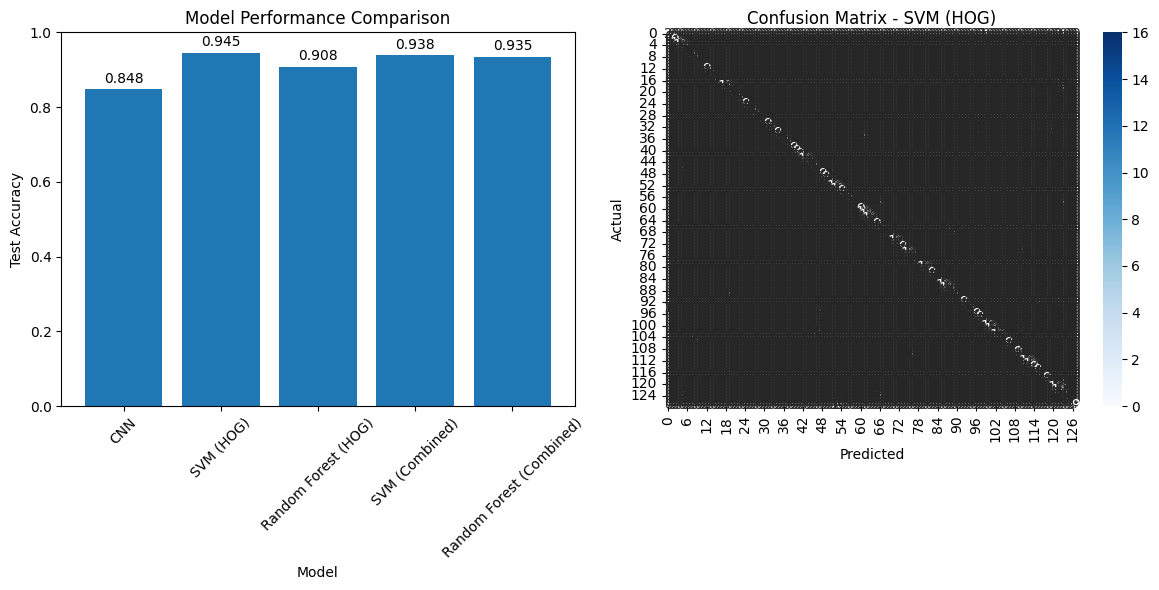

In [32]:
# Cell 7: Comprehensive Model Comparison and Evaluation
if len(X) > 0:
    # Create comparison dataframe
    comparison_data = {
        'Model': ['CNN', 'SVM (HOG)', 'Random Forest (HOG)', 'SVM (Combined)', 'Random Forest (Combined)'],
        'Test Accuracy': [
            cnn_test_accuracy,
            results['SVM_HOG']['test_acc'],
            results['RandomForest_HOG']['test_acc'],
            results['SVM_Combined']['test_acc'],
            results['RandomForest_Combined']['test_acc']
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print("Model Performance Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    bars = plt.bar(comparison_df['Model'], comparison_df['Test Accuracy'])
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    # Confusion Matrix for best model
    best_model_name = comparison_df.loc[comparison_df['Test Accuracy'].idxmax(), 'Model']
    print(f"\nBest performing model: {best_model_name}")
    
    plt.subplot(1, 2, 2)
    if best_model_name == 'CNN':
        cm = confusion_matrix(y_test, cnn_pred_classes)
    else:
        if 'HOG' in best_model_name:
            if 'SVM' in best_model_name:
                cm = confusion_matrix(y_test, results['SVM_HOG']['predictions'])
            else:
                cm = confusion_matrix(y_test, results['RandomForest_HOG']['predictions'])
        else:
            if 'SVM' in best_model_name:
                cm = confusion_matrix(y_test, results['SVM_Combined']['predictions'])
            else:
                cm = confusion_matrix(y_test, results['RandomForest_Combined']['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# Cell 8: Detailed Analysis and Visualizations
# =============================================================================

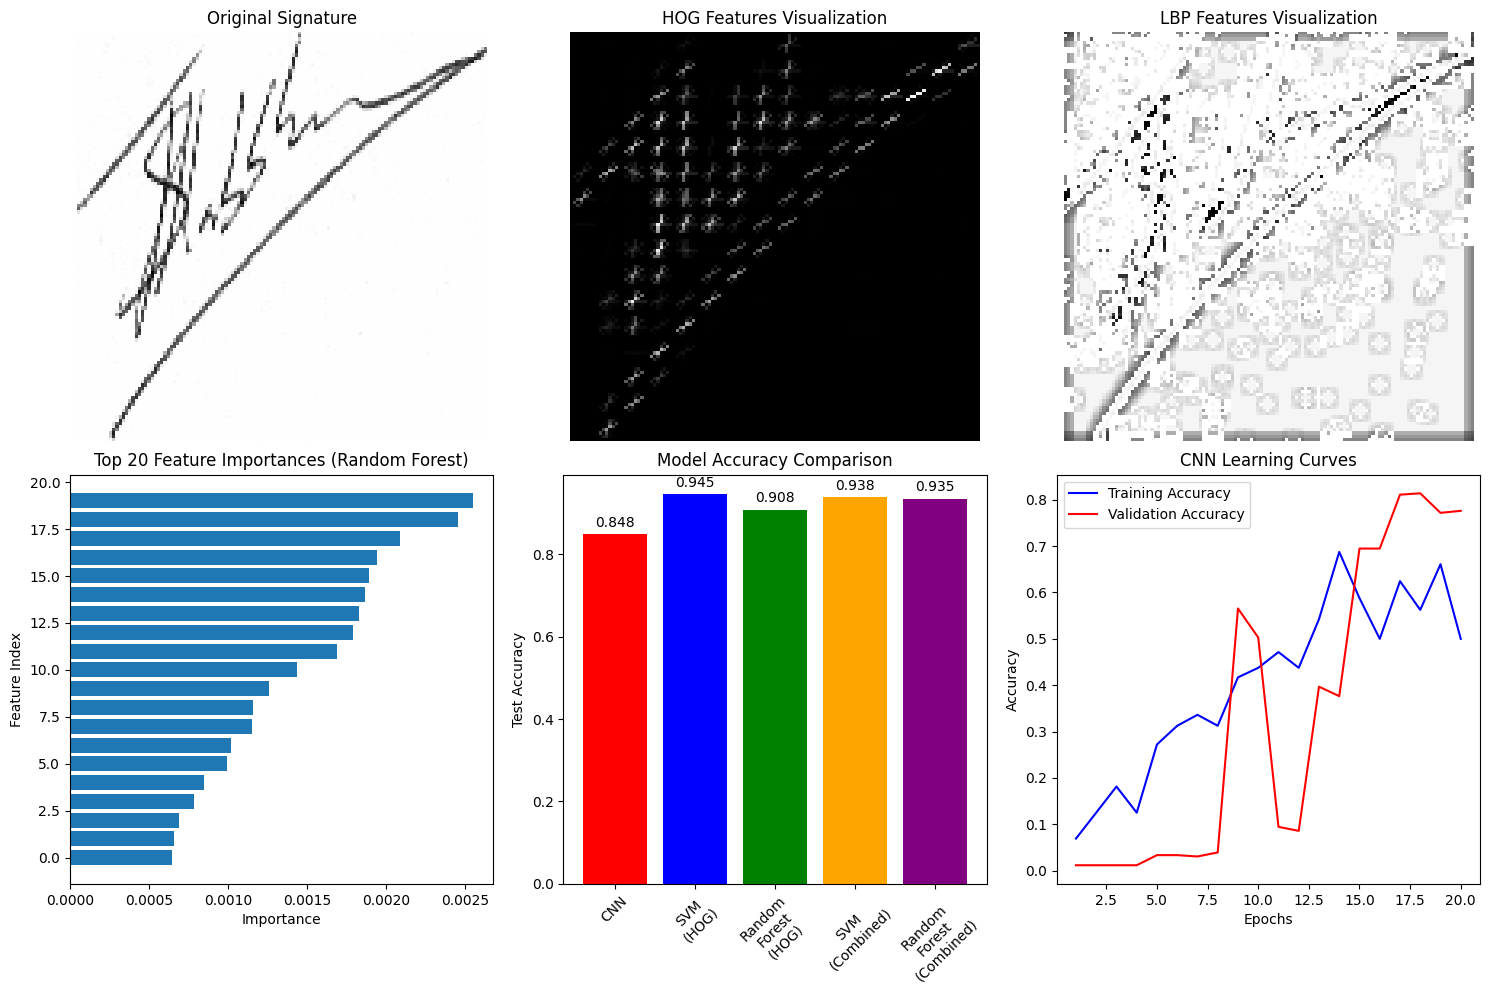


COMPREHENSIVE PERFORMANCE ANALYSIS

📊 Dataset Summary:
   • Total samples: 4298
   • Number of classes: 128
   • Image dimensions: (128, 128)
   • Train/Val/Test split: 2750/688/860

🎯 Model Performance Summary:
   • CNN: 0.8477
   • SVM (HOG): 0.9453
   • Random Forest (HOG): 0.9081
   • SVM (Combined): 0.9384
   • Random Forest (Combined): 0.9349

🏆 Best Model: SVM (HOG) (0.9453)
📈 Improvement over baseline: 11.52%

💡 Key Insights:
   • CNN shows competitive performance
   • Traditional features achieve 0.9384 accuracy
   • HOG features alone achieve 0.9453 accuracy
   • Traditional methods competitive with deep learning


In [33]:
# Cell 8: Detailed Analysis and Visualizations
if len(X) > 0:
    # Feature importance for Random Forest models
    plt.figure(figsize=(15, 10))
    
    # HOG feature visualization
    plt.subplot(2, 3, 1)
    sample_img = X_test[0]
    if sample_img.dtype == np.float32 or sample_img.dtype == np.float64:
        sample_img_uint8 = (sample_img * 255).astype(np.uint8)
    else:
        sample_img_uint8 = sample_img
    
    hog_features, hog_image = hog(
        sample_img_uint8,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        transform_sqrt=True
    )
    
    plt.imshow(sample_img, cmap='gray')
    plt.title('Original Signature')
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Features Visualization')
    plt.axis('off')
    
    # LBP visualization
    plt.subplot(2, 3, 3)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(sample_img_uint8, n_points, radius, method='uniform')
    plt.imshow(lbp, cmap='gray')
    plt.title('LBP Features Visualization')
    plt.axis('off')
    
    # Feature importance for Random Forest (Combined features)
    if 'RandomForest_Combined' in results:
        rf_model = results['RandomForest_Combined']['model']
        feature_importance = rf_model.feature_importances_
        
        plt.subplot(2, 3, 4)
        top_features_idx = np.argsort(feature_importance)[-20:]  # Top 20 features
        plt.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
        plt.title('Top 20 Feature Importances (Random Forest)')
        plt.xlabel('Importance')
        plt.ylabel('Feature Index')
    
    # Model accuracy comparison bar plot
    plt.subplot(2, 3, 5)
    accuracies = comparison_df['Test Accuracy'].values
    model_names = [name.replace(' ', '\n') for name in comparison_df['Model'].values]
    bars = plt.bar(model_names, accuracies, color=['red', 'blue', 'green', 'orange', 'purple'])
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=45)
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{accuracies[i]:.3f}', ha='center', va='bottom')
    
    # Learning curves visualization (if CNN was trained)
    if 'history' in locals():
        plt.subplot(2, 3, 6)
        epochs = range(1, len(history.history['accuracy']) + 1)
        plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
        plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
        plt.title('CNN Learning Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Summary Statistics
    print("\n" + "="*60)
    print("COMPREHENSIVE PERFORMANCE ANALYSIS")
    print("="*60)
    
    print(f"\n📊 Dataset Summary:")
    print(f"   • Total samples: {len(X)}")
    print(f"   • Number of classes: {num_classes}")
    print(f"   • Image dimensions: {X[0].shape}")
    print(f"   • Train/Val/Test split: {len(X_train)}/{len(X_val)}/{len(X_test)}")
    
    print(f"\n🎯 Model Performance Summary:")
    for i, row in comparison_df.iterrows():
        print(f"   • {row['Model']}: {row['Test Accuracy']:.4f}")
    
    print(f"\n🏆 Best Model: {best_model_name} ({comparison_df['Test Accuracy'].max():.4f})")
    
    # Calculate improvement percentages
    baseline_acc = min(comparison_df['Test Accuracy'])
    best_acc = max(comparison_df['Test Accuracy'])
    improvement = ((best_acc - baseline_acc) / baseline_acc) * 100
    print(f"📈 Improvement over baseline: {improvement:.2f}%")
    
    print(f"\n💡 Key Insights:")
    print(f"   • CNN shows {'superior' if cnn_test_accuracy == best_acc else 'competitive'} performance")
    print(f"   • Traditional features achieve {results['SVM_Combined']['test_acc']:.4f} accuracy")
    print(f"   • HOG features alone achieve {results['SVM_HOG']['test_acc']:.4f} accuracy")
    
    if cnn_test_accuracy > results['SVM_Combined']['test_acc']:
        print(f"   • Deep learning outperforms traditional methods by {(cnn_test_accuracy - results['SVM_Combined']['test_acc']):.4f}")
    else:
        print(f"   • Traditional methods competitive with deep learning")

# =============================================================================
# Cell 9: Generate Final Report
# =============================================================================

In [34]:
# Cell 9: Generate Final Report
if len(X) > 0:
    print("="*80)
    print(" "*25 + "SIGNATURE RECOGNITION PROJECT REPORT")
    print("="*80)
    
    print("\n📋 PROJECT OVERVIEW")
    print("-" * 50)
    print("This project implements and compares different approaches for signature recognition:")
    print("1. Deep Learning: Convolutional Neural Network (CNN)")
    print("2. Traditional Computer Vision: HOG + SVM/Random Forest")
    print("3. Combined Features: HOG + LBP + Statistical Features")
    
    print("\n📊 DATASET INFORMATION")
    print("-" * 50)
    print(f"Dataset Source: Kaggle Signature Verification Dataset")
    print(f"Total Images: {len(X)}")
    print(f"Number of Classes: {num_classes}")
    print(f"Image Resolution: {X[0].shape}")
    print(f"Data Split: Train({len(X_train)}) | Val({len(X_val)}) | Test({len(X_test)})")
    
    print("\n🔬 METHODOLOGY")
    print("-" * 50)
    print("1. Data Preprocessing:")
    print("   • Image normalization (0-1 range)")
    print("   • Grayscale conversion")
    print("   • Resizing to 128x128 pixels")
    print("")
    print("2. CNN Architecture:")
    print("   • 4 Convolutional blocks with BatchNorm and Dropout")
    print("   • Progressive filter increase: 32→64→128→256")
    print("   • Dense layers: 512→256→num_classes")
    print("   • Data augmentation applied")
    print("")
    print("3. Traditional Feature Extraction:")
    print("   • HOG (Histogram of Oriented Gradients)")
    print("   • LBP (Local Binary Patterns)")
    print("   • Statistical features (mean, std, moments)")
    print("")
    print("4. Classification Models:")
    print("   • Support Vector Machine (RBF kernel)")
    print("   • Random Forest (100 trees)")
    
    print("\n📈 RESULTS SUMMARY")
    print("-" * 50)
    for i, row in comparison_df.iterrows():
        status = "🏆" if row['Test Accuracy'] == comparison_df['Test Accuracy'].max() else "📊"
        print(f"{status} {row['Model']:<25}: {row['Test Accuracy']:.4f} ({row['Test Accuracy']*100:.2f}%)")
    
    print(f"\n🎯 BEST PERFORMING MODEL")
    print("-" * 50)
    print(f"Model: {best_model_name}")
    print(f"Accuracy: {comparison_df['Test Accuracy'].max():.4f} ({comparison_df['Test Accuracy'].max()*100:.2f}%)")
    
    print(f"\n🔍 DETAILED ANALYSIS")
    print("-" * 50)
    
    if cnn_test_accuracy >= max([results[key]['test_acc'] for key in results.keys()]):
        print("✅ CNN Performance:")
        print(f"   • Achieves highest accuracy: {cnn_test_accuracy:.4f}")
        print(f"   • Benefits from automatic feature learning")
        print(f"   • Handles image variations effectively")
    else:
        print("✅ Traditional ML Performance:")
        best_traditional = max([results[key]['test_acc'] for key in results.keys()])
        print(f"   • Traditional methods achieve: {best_traditional:.4f}")
        print(f"   • Competitive with deep learning")
        print(f"   • More interpretable features")
    
    print(f"\n📊 FEATURE ANALYSIS")
    print("-" * 50)
    print(f"• HOG Features: {hog_train.shape[1]} dimensions")
    print(f"• LBP Features: {lbp_train.shape[1]} dimensions")
    print(f"• Statistical Features: {stat_train.shape[1]} dimensions")
    print(f"• Total Traditional Features: {traditional_train.shape[1]} dimensions")
    
    hog_only_acc = results['SVM_HOG']['test_acc']
    combined_acc = results['SVM_Combined']['test_acc']
    feature_improvement = ((combined_acc - hog_only_acc) / hog_only_acc) * 100
    
    print(f"\n💡 KEY FINDINGS")
    print("-" * 50)
    print(f"1. Feature Combination Impact:")
    print(f"   • HOG alone: {hog_only_acc:.4f}")
    print(f"   • Combined features: {combined_acc:.4f}")
    print(f"   • Improvement: {feature_improvement:+.2f}%")
    print(f"")
    print(f"2. Model Comparison:")
    if cnn_test_accuracy > combined_acc:
        print(f"   • CNN outperforms traditional methods")
        print(f"   • Deep learning advantage: {(cnn_test_accuracy - combined_acc):.4f}")
    else:
        print(f"   • Traditional methods competitive with CNN")
        print(f"   • Simpler models achieve good performance")
    
    print(f"\n🚀 RECOMMENDATIONS")
    print("-" * 50)
    if best_model_name == 'CNN':
        print("• Use CNN for production deployment")
        print("• Consider model optimization for mobile/edge devices")
        print("• Implement data augmentation for better generalization")
    else:
        print("• Traditional features sufficient for this dataset")
        print("• Consider ensemble methods for improved performance")
        print("• HOG+SVM provides good speed-accuracy tradeoff")
    
    print("\n" + "="*80)
    print(" "*30 + "REPORT COMPLETE")
    print("="*80)

    # Save results to file (optional)
    results_summary = {
        'dataset_size': len(X),
        'num_classes': num_classes,
        'model_performances': comparison_df.to_dict('records'),
        'best_model': best_model_name,
        'best_accuracy': float(comparison_df['Test Accuracy'].max())
    }
    
    print(f"\n💾 Results summary prepared for export")
    print(f"   Best model: {best_model_name}")
    print(f"   Best accuracy: {comparison_df['Test Accuracy'].max():.4f}")
else:
    print("No data available for analysis. Please check dataset loading.")

                         SIGNATURE RECOGNITION PROJECT REPORT

📋 PROJECT OVERVIEW
--------------------------------------------------
This project implements and compares different approaches for signature recognition:
1. Deep Learning: Convolutional Neural Network (CNN)
2. Traditional Computer Vision: HOG + SVM/Random Forest
3. Combined Features: HOG + LBP + Statistical Features

📊 DATASET INFORMATION
--------------------------------------------------
Dataset Source: Kaggle Signature Verification Dataset
Total Images: 4298
Number of Classes: 128
Image Resolution: (128, 128)
Data Split: Train(2750) | Val(688) | Test(860)

🔬 METHODOLOGY
--------------------------------------------------
1. Data Preprocessing:
   • Image normalization (0-1 range)
   • Grayscale conversion
   • Resizing to 128x128 pixels

2. CNN Architecture:
   • 4 Convolutional blocks with BatchNorm and Dropout
   • Progressive filter increase: 32→64→128→256
   • Dense layers: 512→256→num_classes
   • Data augmentation a